Coronal View Segmentation for HC Subject:


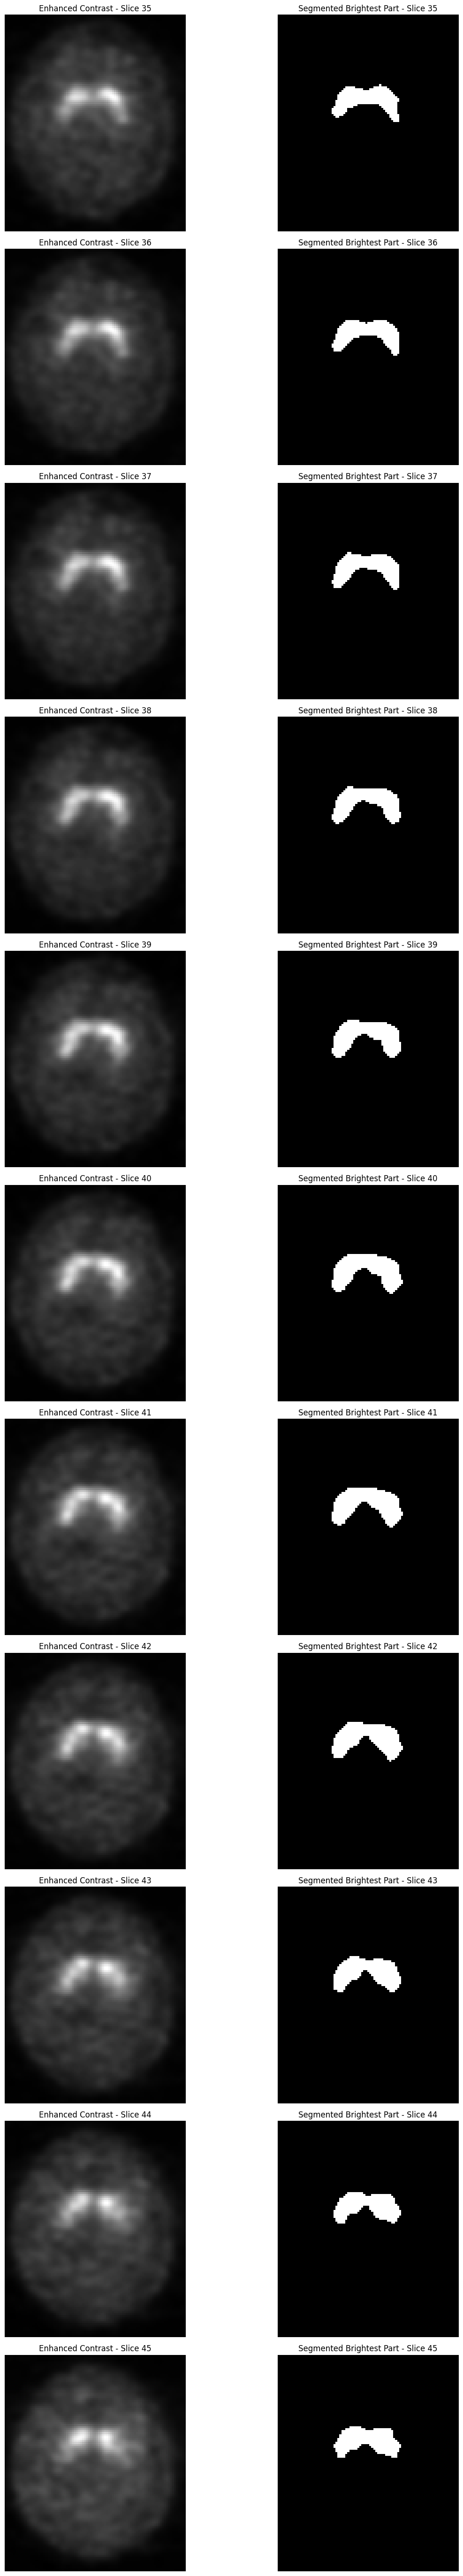


Coronal View Segmentation for PD Subject:


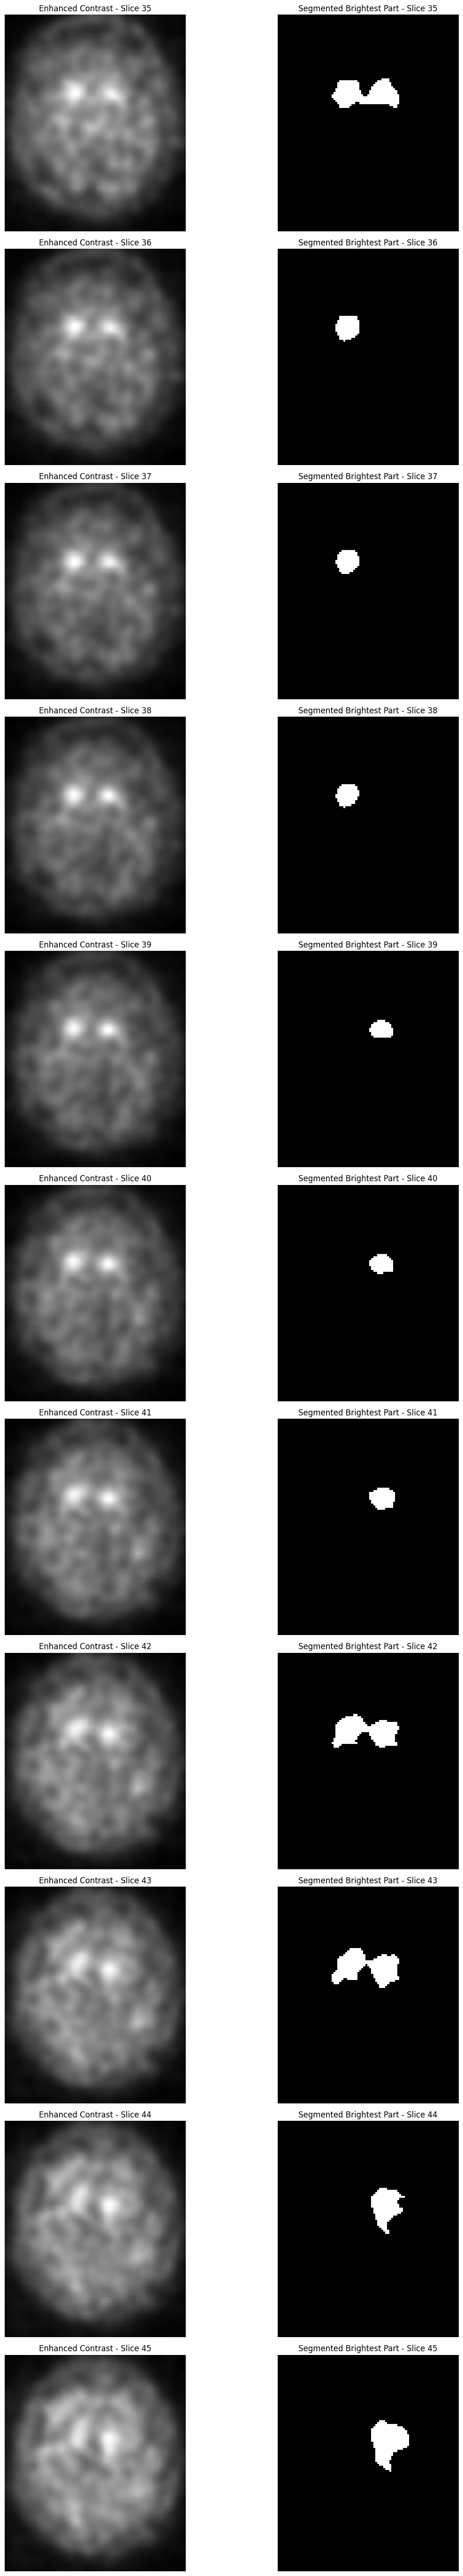

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from skimage import exposure, measure

def segment_coronal_view(dicom_dir, threshold_value=0.7):
    dicom_files = sorted([os.path.join(dicom_dir, file) for file in os.listdir(dicom_dir) if file.endswith('.dcm')])

    try:
        dicom_data = [pydicom.dcmread(file) for file in dicom_files]
        preprocessed_image_data = np.stack([dicom.pixel_array for dicom in dicom_data])

        # Remove single channel dimension if present
        preprocessed_image_data = np.squeeze(preprocessed_image_data)
    except Exception as e:
        print("Error loading DICOM data:", e)
        return None

    # Parameters
    #threshold_value = 0.7  # Adjust threshold for the brightest part

    # Segmentation for coronal slices
    coronal_slices_to_visualize = [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
    num_slices = len(coronal_slices_to_visualize)

    fig, axes = plt.subplots(num_slices, 2, figsize=(14, 5 * num_slices))

    merged_striatum_image = np.zeros_like(preprocessed_image_data, dtype=np.uint8)

    for i, slice_index in enumerate(coronal_slices_to_visualize):
        # Get the coronal slice
        coronal_slice = preprocessed_image_data[slice_index, :, :]

        # Apply custom intensity transformation
        coronal_slice_contrast = exposure.rescale_intensity(coronal_slice, in_range='image', out_range=(0.1, 0.9))

        # Apply threshold to isolate the brightest part
        brightest_part = coronal_slice_contrast > np.max(coronal_slice_contrast) * threshold_value

        # Label connected components
        labeled_image, num_labels = measure.label(brightest_part, connectivity=2, return_num=True)

        # Find the largest connected component (assumed to be the striatum)
        region_props = measure.regionprops(labeled_image, intensity_image=coronal_slice)
        brightest_region_label = None
        brightest_mean_intensity = 0
        for region in region_props:
            if region.mean_intensity > brightest_mean_intensity:
                brightest_mean_intensity = region.mean_intensity
                brightest_region_label = region.label

        # Create mask for the brightest region
        brightest_region_mask = labeled_image == brightest_region_label

        # Overlay the mask on the original image
        merged_striatum_image[slice_index][brightest_region_mask] = 255

        # Apply additional intensity transformation to make the brightest part even brighter
        merged_striatum_image[slice_index] = exposure.rescale_intensity(merged_striatum_image[slice_index], out_range=(0, 255))

        # Apply additional intensity transformation to make the darkest part darker
        coronal_slice_contrast = exposure.rescale_intensity(coronal_slice_contrast, out_range=(0.05, 0.8))

        # Original image
        axes[i, 0].imshow(coronal_slice_contrast, cmap='gray')
        axes[i, 0].set_title(f'Enhanced Contrast - Slice {slice_index}')
        axes[i, 0].axis('off')

        # Segmented striatum region
        axes[i, 1].imshow(merged_striatum_image[slice_index], cmap='bone')
        axes[i, 1].set_title(f'Segmented Brightest Part - Slice {slice_index}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


# Paths to DICOM directories
hc_dicom_dir = "B:/Sami Sir Research/Data set/hc/PPMI/3370/Reconstructed_DaTSCAN/2011-11-30_15_13_13.0/I339919"
pd_dicom_dir = "B:/Sami Sir Research/Data set/pd/PPMI/140258/Reconstructed_DaTSCAN/2022-08-04_14_50_16.0/I1615951"

# Segment coronal views with default threshold value
print("Coronal View Segmentation for HC Subject:")
segment_coronal_view(hc_dicom_dir,threshold_value=0.544999)

print("\nCoronal View Segmentation for PD Subject:")
segment_coronal_view(pd_dicom_dir,threshold_value=0.67999999)




Coronal View Segmentation and Coloring for PD Subject:


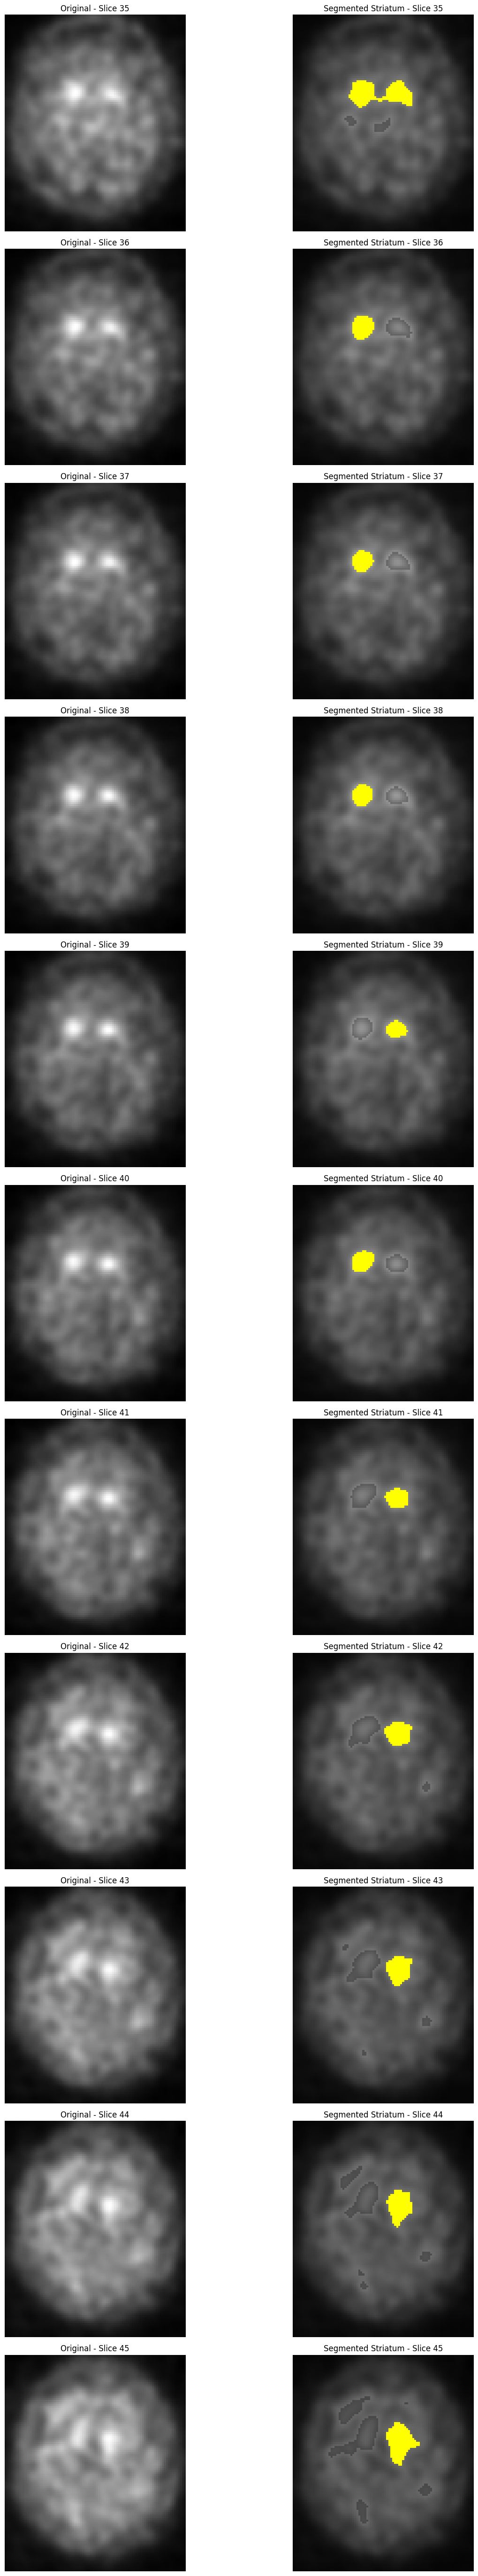

Coronal View Segmentation and Coloring for HC Subject:


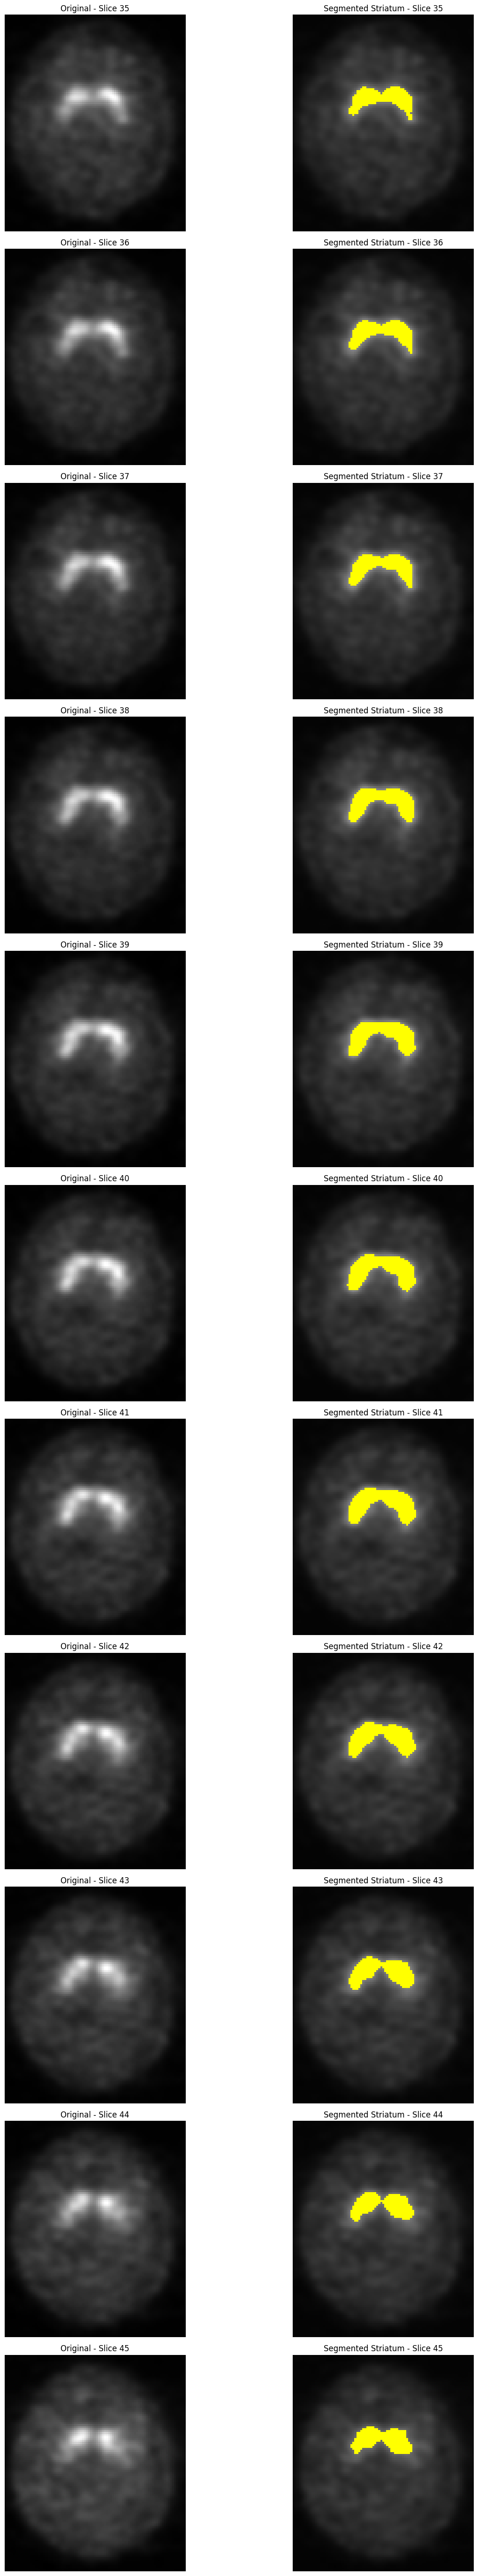

In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from skimage import measure, color

def segment_and_color_coronal_view(dicom_dir, threshold_value):
    # Load DICOM data
    dicom_files = sorted([os.path.join(dicom_dir, file) for file in os.listdir(dicom_dir) if file.endswith('.dcm')])

    try:
        dicom_data = [pydicom.dcmread(file) for file in dicom_files]
        preprocessed_image_data = np.stack([dicom.pixel_array for dicom in dicom_data])
        
        # Remove single channel dimension if present
        preprocessed_image_data = np.squeeze(preprocessed_image_data)
    except Exception as e:
        print("Error loading DICOM data:", e)
        return

    # Parameters
    # threshold_value = 0.5678  # Threshold for segmentation, adjust as needed

    # Segmentation for coronal slices
    coronal_slices_to_visualize = [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
    num_slices = len(coronal_slices_to_visualize)

    fig, axes = plt.subplots(num_slices, 2, figsize=(15, 5 * num_slices))

    for i, slice_index in enumerate(coronal_slices_to_visualize):
        # Get the coronal slice
        coronal_slice = preprocessed_image_data[slice_index, :, :]

        # Thresholding to obtain the brightest region
        binary_image = coronal_slice > np.max(coronal_slice) * threshold_value

        # Label connected components
        labeled_image, num_labels = measure.label(binary_image, connectivity=2, return_num=True)

        # Find the largest connected component (assumed to be the striatum)
        region_props = measure.regionprops(labeled_image, intensity_image=coronal_slice)
        brightest_region_label = None
        brightest_mean_intensity = 0
        for region in region_props:
            if region.mean_intensity > brightest_mean_intensity:
                brightest_mean_intensity = region.mean_intensity
                brightest_region_label = region.label

        # Create mask for the brightest region
        brightest_region_mask = labeled_image == brightest_region_label

        # Overlay the mask on the original image
        masked_image = color.label2rgb(labeled_image, image=coronal_slice, bg_label=0, bg_color=None, colors=['black'], alpha=0.3, image_alpha=1)
        masked_image[brightest_region_mask] = [1, 1, 0]  # Highlight brightest region with yellow color

        # Original image
        axes[i, 0].imshow(coronal_slice, cmap='gray')
        axes[i, 0].set_title(f'Original - Slice {slice_index}')
        axes[i, 0].axis('off')

        # Segmented striatum region
        axes[i, 1].imshow(masked_image)
        axes[i, 1].set_title(f'Segmented Striatum - Slice {slice_index}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


# Paths to DICOM directories
dicom_dir_hc = "B:/Sami Sir Research/Data set/hc/PPMI/3370/Reconstructed_DaTSCAN/2011-11-30_15_13_13.0/I339919"
dicom_dir_pd = "B:/Sami Sir Research/Data set/pd/PPMI/140258/Reconstructed_DaTSCAN/2022-08-04_14_50_16.0/I1615951"


print("\nCoronal View Segmentation and Coloring for PD Subject:")
segment_and_color_coronal_view(dicom_dir_pd,threshold_value=0.67999999)

# Segment and color coronal views for both subjects
print("Coronal View Segmentation and Coloring for HC Subject:")
segment_and_color_coronal_view(dicom_dir_hc,threshold_value=0.544999)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

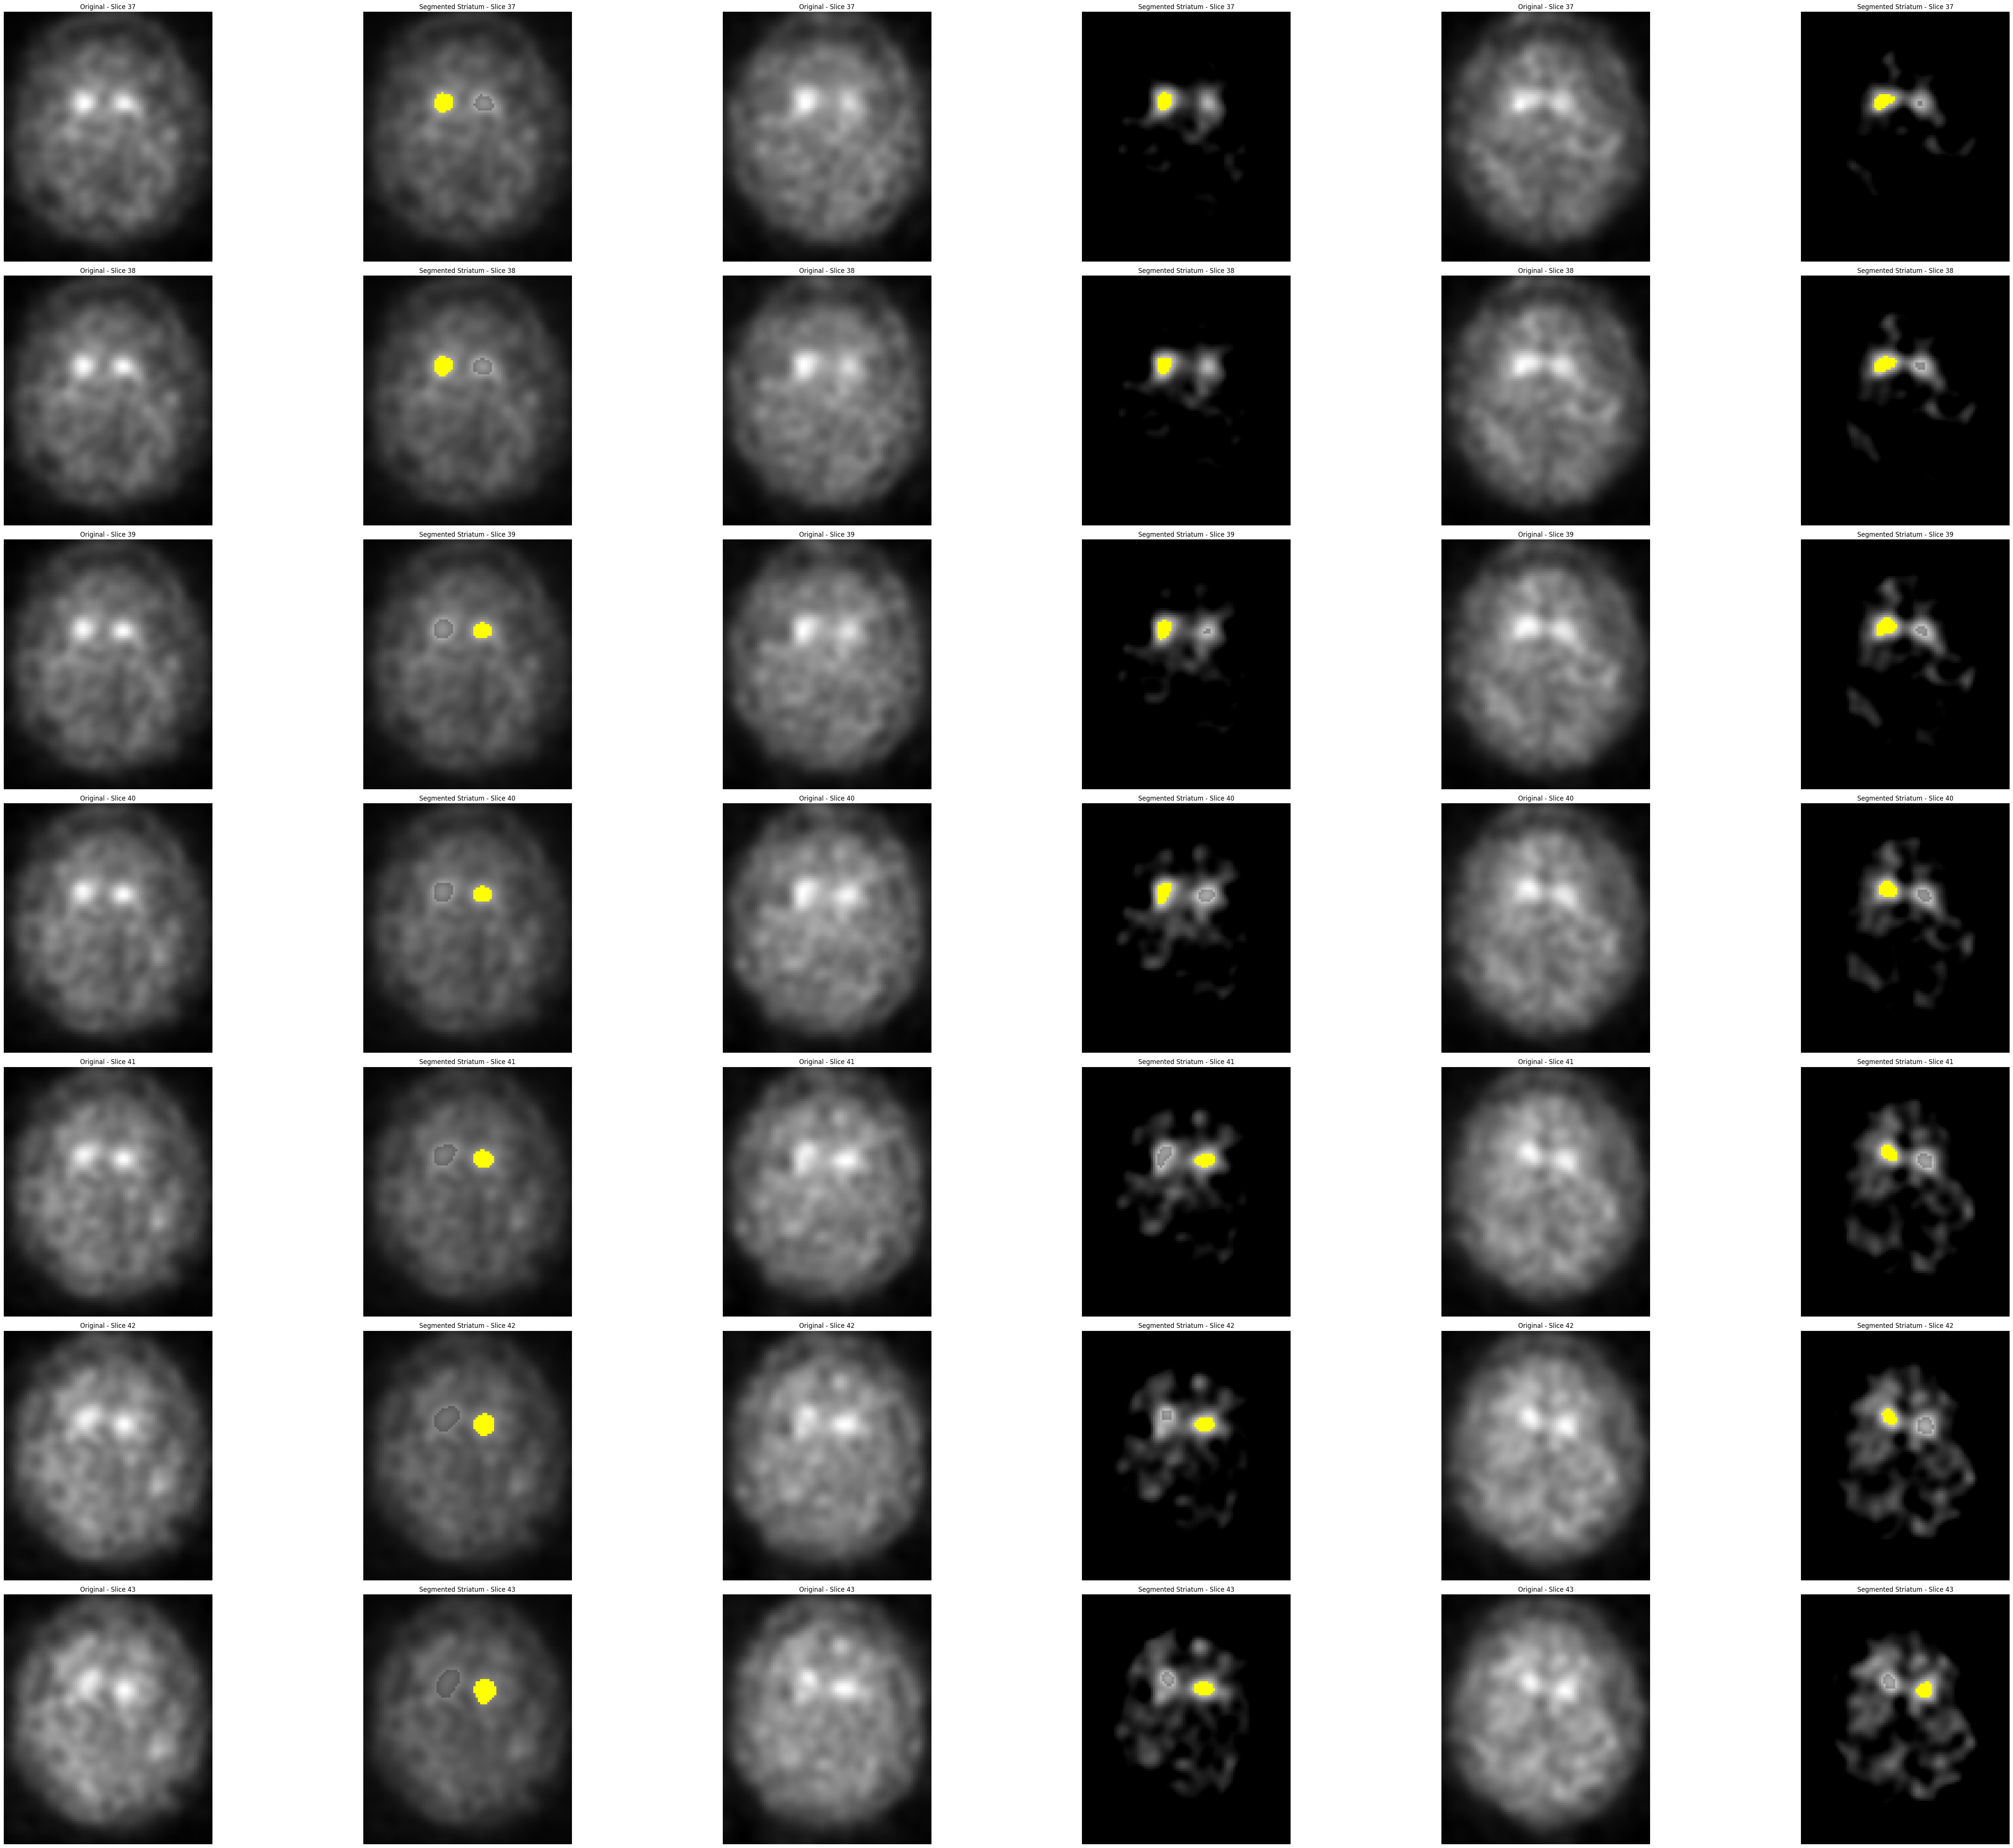

In [58]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from skimage import measure, color, filters

# Directories of the DICOM files
dicom_dirs = [
    "B:/Sami Sir Research/Data set/pd/PPMI/140258/Reconstructed_DaTSCAN/2022-08-04_14_50_16.0/I1615951",
    "B:/Sami Sir Research/Data set/pd/PPMI/140258/Reconstructed_DaTSCAN/2023-07-13_16_38_33.0/I10380680",
    "B:/Sami Sir Research/Data set/pd/PPMI/140258/Reconstructed_DaTSCAN/2023-10-19_15_27_59.0/I10380681"
]

# Parameters
threshold_value = 0.8  # Threshold for segmentation, adjust as needed

# Segmentation and coloring for coronal slices
coronal_slices_to_visualize = [37, 38, 39, 40, 41, 42, 43]
num_slices = len(coronal_slices_to_visualize)

fig, axes = plt.subplots(num_slices, len(dicom_dirs) * 2, figsize=(20 * len(dicom_dirs), 7 * num_slices))

for j, dicom_dir in enumerate(dicom_dirs):
    # Load DICOM data
    dicom_files = sorted([os.path.join(dicom_dir, file) for file in os.listdir(dicom_dir) if file.endswith('.dcm')])
    try:
        dicom_data = [pydicom.dcmread(file) for file in dicom_files]
        preprocessed_image_data = np.stack([dicom.pixel_array for dicom in dicom_data])

        # Remove single channel dimension if present
        preprocessed_image_data = np.squeeze(preprocessed_image_data)
    except Exception as e:
        print("Error loading DICOM data:", e)
        continue

    for i, slice_index in enumerate(coronal_slices_to_visualize):
        # Get the coronal slice
        coronal_slice = preprocessed_image_data[slice_index, :, :]

        # Apply thresholding to obtain the brightest region
        threshold = np.percentile(coronal_slice, 99.9)  # Set threshold to 99.9 percentile of pixel intensities
        binary_image = coronal_slice > threshold * threshold_value

        # Label connected components
        labeled_image, num_labels = measure.label(binary_image, connectivity=2, return_num=True)

        # Find the largest connected component (assumed to be the striatum)
        region_props = measure.regionprops(labeled_image, intensity_image=coronal_slice)
        brightest_region_label = None
        brightest_mean_intensity = 0
        for region in region_props:
            if region.mean_intensity > brightest_mean_intensity:
                brightest_mean_intensity = region.mean_intensity
                brightest_region_label = region.label

        # Create mask for the brightest region
        brightest_region_mask = labeled_image == brightest_region_label

        # Overlay the mask on the original image
        masked_image = color.label2rgb(labeled_image, image=coronal_slice, bg_label=0, bg_color=None, colors=['black'], alpha=0.3, image_alpha=1)
        masked_image[brightest_region_mask] = [1, 1, 0]  # Highlight the brightest region with yellow color

        # Original image
        axes[i, j * 2].imshow(coronal_slice, cmap='gray')
        axes[i, j * 2].set_title(f'Original - Slice {slice_index}')
        axes[i, j * 2].axis('off')

        # Segmented striatum region
        axes[i, j * 2 + 1].imshow(masked_image)
        axes[i, j * 2 + 1].set_title(f'Segmented Striatum - Slice {slice_index}')
        axes[i, j * 2 + 1].axis('off')

plt.tight_layout()
plt.show()
